Saved:
  figures/learning_curves_placeholder.pdf
  figures/learning_curves_placeholder.png


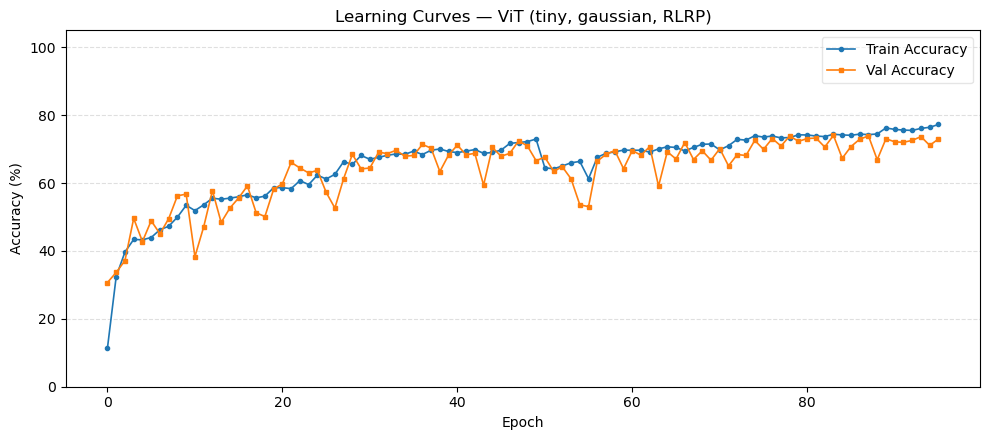

In [1]:
# save as: plot_learning_curves.py
import json, os
from glob import glob
import matplotlib.pyplot as plt

# ------------- config -------------
pattern = "epoch_metrics*.json"   # e.g., epoch_metrics_run1.json, epoch_metrics_run2.json
out_pdf = "figures/learning_curves_placeholder.pdf"
out_png = "figures/learning_curves_placeholder.png"
model_label = "ViT (tiny, gaussian, RLRP)"  # shown in title
# ----------------------------------

# 1) collect files (add more later; rerun to update)
files = sorted(glob(pattern))
if not files:
    raise FileNotFoundError(f"No files match {pattern} in current directory.")

# 2) helper to parse one file into lists
def parse_epoch_file(path):
    """
    Accepts either:
      - a JSON list of epoch dicts, or
      - a dict with key 'epochs' that is the list.
    Expected keys per-epoch (best effort): 'epoch', 'train_acc', 'val_acc'
    Fallbacks: 'train_accuracy', 'val_accuracy' if present.
    Acc values can be [0,1] or [%].
    """
    with open(path, "r") as f:
        data = json.load(f)

    if isinstance(data, dict) and "epochs" in data:
        records = data["epochs"]
    elif isinstance(data, list):
        records = data
    else:
        # Some logs store step-wise dict; try common key
        records = data.get("history", [])

    ep, tr, va = [], [], []
    for r in records:
        e  = r.get("epoch", None)
        ta = r.get("train_acc", r.get("train_accuracy"))
        va_ = r.get("val_acc", r.get("val_accuracy"))
        if e is None or ta is None or va_ is None:
            # try alt names used earlier
            ta = ta if ta is not None else r.get("train", {}).get("acc")
            va_ = va_ if va_ is not None else r.get("val", {}).get("acc")
        if (ta is None) or (va_ is None):
            continue
        # normalize to %
        if 0 <= ta <= 1: ta *= 100.0
        if 0 <= va_ <= 1: va_ *= 100.0
        ep.append(int(e) if e is not None else len(ep))
        tr.append(float(ta))
        va.append(float(va_))
    return ep, tr, va

# 3) concatenate runs with continuous epoch indexing
all_epochs, all_train, all_val = [], [], []
epoch_offset = 0
for path in files:
    ep, tr, va = parse_epoch_file(path)
    if not ep:
        continue
    # rebase epochs to continue after previous
    # ensure monotonic 0..N for this chunk
    # use the order they appear, regardless of their internal epoch numbering
    for i in range(len(ep)):
        all_epochs.append(epoch_offset + i)
        all_train.append(tr[i])
        all_val.append(va[i])
    epoch_offset += len(ep)

# 4) plot (single chart, two lines; no explicit colors/styles)
import numpy as np
os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
fig, ax = plt.subplots(figsize=(10, 4.5))

ax.plot(all_epochs, all_train, marker='o', linewidth=1.2, markersize=3, label="Train Accuracy")
ax.plot(all_epochs, all_val,   marker='s', linewidth=1.2, markersize=3, label="Val Accuracy")

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
ax.set_title(f"Learning Curves — {model_label}")
ax.set_ylim(0, 105)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(frameon=True, framealpha=0.5)

fig.tight_layout()
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Saved:\n  {out_pdf}\n  {out_png}")


Saved:
  figures/learning_curves_placeholder.pdf
  figures/learning_curves_placeholder.png


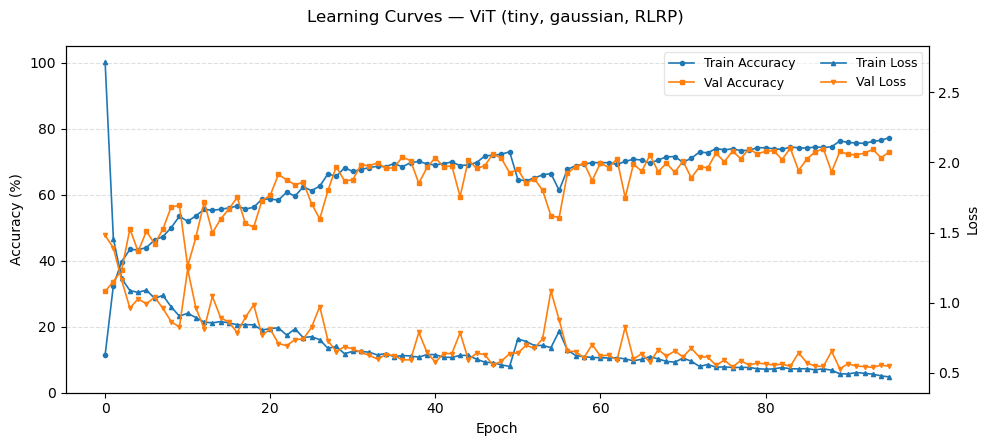

In [2]:
# save as: plot_learning_curves.py
import json, os
from glob import glob
import matplotlib.pyplot as plt

# -------- configuration --------
pattern = "epoch_metrics*.json"   # e.g., epoch_metrics_run1.json, epoch_metrics_run2.json
out_pdf = "figures/learning_curves_placeholder.pdf"
out_png = "figures/learning_curves_placeholder.png"
model_label = r"ViT (tiny, gaussian, RLRP)"  # shown in title
# --------------------------------

def parse_epoch_file(path):
    """
    Accepts either:
      - a JSON list of epoch dicts, or
      - a dict with key 'epochs' that is the list, or
      - a dict with key 'history' that is the list.
    Per-epoch keys (best effort): 
      'epoch', 'train_acc' or 'train_accuracy', 'val_acc' or 'val_accuracy',
      'train_loss', 'val_loss'.
    Acc values can be [0,1] or already in %.
    """
    with open(path, "r") as f:
        data = json.load(f)

    if isinstance(data, list):
        records = data
    elif isinstance(data, dict):
        if "epochs" in data:
            records = data["epochs"]
        elif "history" in data:
            records = data["history"]
        else:
            # assume it's already a single-epoch dict list in some nested key; fallback to flatten none
            records = []
    else:
        records = []

    ep, tr_acc, va_acc, tr_loss, va_loss = [], [], [], [], []
    for i, r in enumerate(records):
        e = r.get("epoch", i)
        # accuracy fields
        ta = r.get("train_acc", r.get("train_accuracy"))
        va = r.get("val_acc",   r.get("val_accuracy"))
        # loss fields
        tl = r.get("train_loss", r.get("loss", r.get("train", {}).get("loss")))
        vl = r.get("val_loss",   r.get("val", {}).get("loss"))

        # skip if both accs and losses are missing
        if ta is None and va is None and tl is None and vl is None:
            continue

        # normalize accuracy to %
        if ta is not None and 0 <= ta <= 1:
            ta *= 100.0
        if va is not None and 0 <= va <= 1:
            va *= 100.0

        ep.append(int(e))
        tr_acc.append(float(ta) if ta is not None else None)
        va_acc.append(float(va) if va is not None else None)
        tr_loss.append(float(tl) if tl is not None else None)
        va_loss.append(float(vl) if vl is not None else None)

    return ep, tr_acc, va_acc, tr_loss, va_loss

# 1) collect and sort files
files = sorted(glob(pattern))
if not files:
    raise FileNotFoundError(f"No files match {pattern} in current directory.")

# 2) concatenate runs with continuous epoch indexing
all_ep, all_tr_acc, all_va_acc, all_tr_loss, all_va_loss = [], [], [], [], []
offset = 0
for p in files:
    ep, tra, vaa, trl, val = parse_epoch_file(p)
    # rebase epochs so the second run continues after the first
    for i in range(len(ep)):
        all_ep.append(offset + i)
        all_tr_acc.append(tra[i] if i < len(tra) else None)
        all_va_acc.append(vaa[i] if i < len(vaa) else None)
        all_tr_loss.append(trl[i] if i < len(trl) else None)
        all_va_loss.append(val[i] if i < len(val) else None)
    offset += len(ep)

# 3) plot: single figure, accuracy on left y-axis, loss on right y-axis
os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
fig, ax1 = plt.subplots(figsize=(10, 4.5))

# Accuracy (left axis)
acc_train_line, = ax1.plot(all_ep, all_tr_acc, marker='o', linewidth=1.2, markersize=3, label="Train Accuracy")
acc_val_line,   = ax1.plot(all_ep, all_va_acc, marker='s', linewidth=1.2, markersize=3, label="Val Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(0, 105)
ax1.grid(axis="y", linestyle="--", alpha=0.4)

# Loss (right axis)
ax2 = ax1.twinx()
loss_train_line, = ax2.plot(all_ep, all_tr_loss, marker='^', linewidth=1.2, markersize=3, label="Train Loss")
loss_val_line,   = ax2.plot(all_ep, all_va_loss, marker='v', linewidth=1.2, markersize=3, label="Val Loss")
ax2.set_ylabel("Loss")

# Title and legend (combine both axes)
fig.suptitle(f"Learning Curves — {model_label}", y=0.98)

lines = [acc_train_line, acc_val_line, loss_train_line, loss_val_line]
labels = [l.get_label() for l in lines]
leg = ax1.legend(lines, labels, ncols=2, fontsize=9, frameon=True, framealpha=0.5, loc="upper right")

fig.tight_layout()
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Saved:\n  {out_pdf}\n  {out_png}")


Saved: figures/learning_curves_placeholder.pdf, figures/learning_curves_placeholder.png


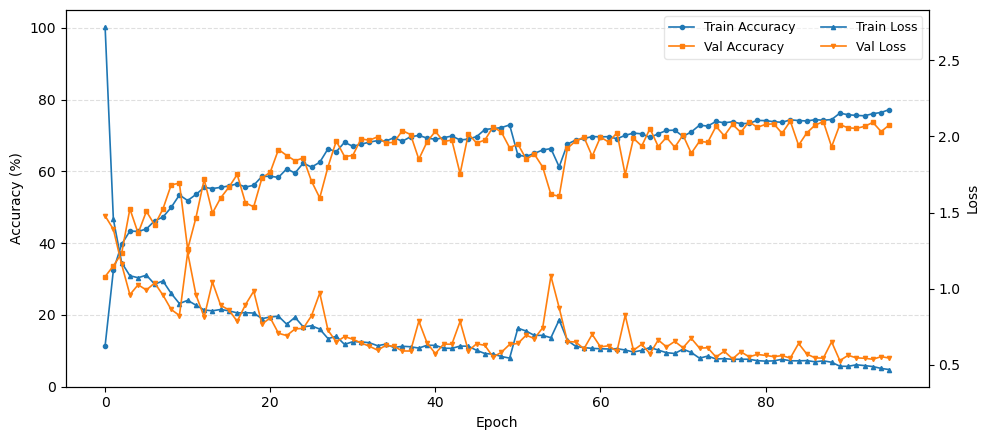

In [3]:
# plot_learning_curves.py
import json, os
from glob import glob
import matplotlib.pyplot as plt

pattern = "epoch_metrics*.json"
out_pdf = "figures/learning_curves_placeholder.pdf"
out_png = "figures/learning_curves_placeholder.png"

def parse_epoch_file(path):
    with open(path, "r") as f:
        data = json.load(f)
    records = data if isinstance(data, list) else data.get("epochs", data.get("history", []))

    ep, tr_acc, va_acc, tr_loss, va_loss = [], [], [], [], []
    for i, r in enumerate(records):
        e = r.get("epoch", i)
        ta = r.get("train_acc", r.get("train_accuracy"))
        va = r.get("val_acc", r.get("val_accuracy"))
        tl = r.get("train_loss", r.get("loss", r.get("train", {}).get("loss")))
        vl = r.get("val_loss", r.get("val", {}).get("loss"))
        if ta is None and va is None and tl is None and vl is None:
            continue
        if ta is not None and 0 <= ta <= 1: ta *= 100
        if va is not None and 0 <= va <= 1: va *= 100
        ep.append(int(e))
        tr_acc.append(ta if ta is not None else None)
        va_acc.append(va if va is not None else None)
        tr_loss.append(tl if tl is not None else None)
        va_loss.append(vl if vl is not None else None)
    return ep, tr_acc, va_acc, tr_loss, va_loss

files = sorted(glob(pattern))
if not files:
    raise FileNotFoundError("No epoch_metrics*.json files found.")

all_ep, all_tr_acc, all_va_acc, all_tr_loss, all_va_loss = [], [], [], [], []
offset = 0
for p in files:
    ep, tra, vaa, trl, val = parse_epoch_file(p)
    for i in range(len(ep)):
        all_ep.append(offset + i)
        all_tr_acc.append(tra[i])
        all_va_acc.append(vaa[i])
        all_tr_loss.append(trl[i])
        all_va_loss.append(val[i])
    offset += len(ep)

os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
fig, ax1 = plt.subplots(figsize=(10, 4.5))

# Accuracy curves
acc_train_line, = ax1.plot(all_ep, all_tr_acc, marker='o', linewidth=1.2, markersize=3, label="Train Accuracy")
acc_val_line,   = ax1.plot(all_ep, all_va_acc, marker='s', linewidth=1.2, markersize=3, label="Val Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(0, 105)
ax1.grid(axis="y", linestyle="--", alpha=0.4)

# Loss curves
ax2 = ax1.twinx()
loss_train_line, = ax2.plot(all_ep, all_tr_loss, marker='^', linewidth=1.2, markersize=3, label="Train Loss")
loss_val_line,   = ax2.plot(all_ep, all_va_loss, marker='v', linewidth=1.2, markersize=3, label="Val Loss")
ax2.set_ylabel("Loss")

# Combined legend
lines = [acc_train_line, acc_val_line, loss_train_line, loss_val_line]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, ncols=2, fontsize=9, frameon=True, framealpha=0.5, loc="upper right")

fig.tight_layout()
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Saved: {out_pdf}, {out_png}")


Saved: figures/learning_curves_placeholder.pdf, figures/learning_curves_placeholder.png


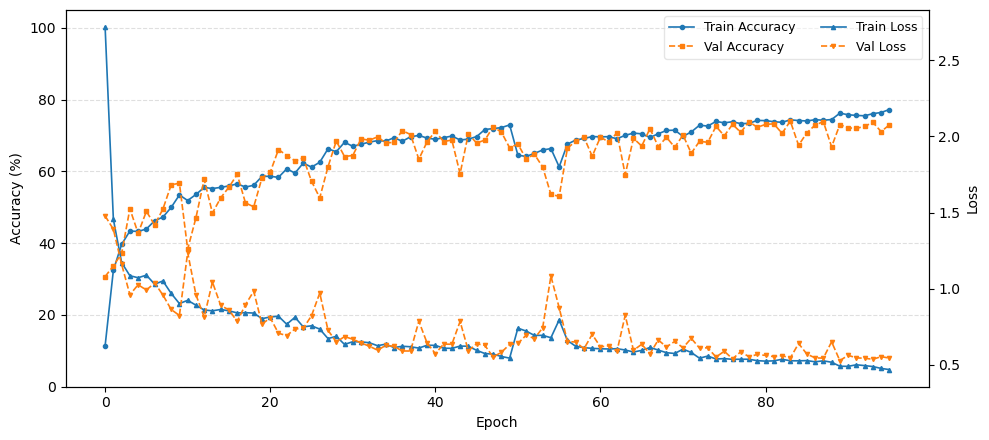

In [4]:
# plot_learning_curves.py
import json, os
from glob import glob
import matplotlib.pyplot as plt

pattern = "epoch_metrics*.json"
out_pdf = "figures/learning_curves_placeholder.pdf"
out_png = "figures/learning_curves_placeholder.png"

def parse_epoch_file(path):
    with open(path, "r") as f:
        data = json.load(f)
    records = data if isinstance(data, list) else data.get("epochs", data.get("history", []))

    ep, tr_acc, va_acc, tr_loss, va_loss = [], [], [], [], []
    for i, r in enumerate(records):
        e = r.get("epoch", i)
        ta = r.get("train_acc", r.get("train_accuracy"))
        va = r.get("val_acc", r.get("val_accuracy"))
        tl = r.get("train_loss", r.get("loss", r.get("train", {}).get("loss")))
        vl = r.get("val_loss", r.get("val", {}).get("loss"))
        if ta is None and va is None and tl is None and vl is None:
            continue
        if ta is not None and 0 <= ta <= 1: ta *= 100
        if va is not None and 0 <= va <= 1: va *= 100
        ep.append(int(e))
        tr_acc.append(ta if ta is not None else None)
        va_acc.append(va if va is not None else None)
        tr_loss.append(tl if tl is not None else None)
        va_loss.append(vl if vl is not None else None)
    return ep, tr_acc, va_acc, tr_loss, va_loss

files = sorted(glob(pattern))
if not files:
    raise FileNotFoundError("No epoch_metrics*.json files found.")

all_ep, all_tr_acc, all_va_acc, all_tr_loss, all_va_loss = [], [], [], [], []
offset = 0
for p in files:
    ep, tra, vaa, trl, val = parse_epoch_file(p)
    for i in range(len(ep)):
        all_ep.append(offset + i)
        all_tr_acc.append(tra[i])
        all_va_acc.append(vaa[i])
        all_tr_loss.append(trl[i])
        all_va_loss.append(val[i])
    offset += len(ep)

os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
fig, ax1 = plt.subplots(figsize=(10, 4.5))

# Accuracy curves
acc_train_line, = ax1.plot(all_ep, all_tr_acc, linestyle='-', marker='o',
                           linewidth=1.2, markersize=3, label="Train Accuracy")
acc_val_line,   = ax1.plot(all_ep, all_va_acc, linestyle='--', marker='s',
                           linewidth=1.2, markersize=3, label="Val Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(0, 105)
ax1.grid(axis="y", linestyle="--", alpha=0.4)

# Loss curves
ax2 = ax1.twinx()
loss_train_line, = ax2.plot(all_ep, all_tr_loss, linestyle='-', marker='^',
                            linewidth=1.2, markersize=3, label="Train Loss")
loss_val_line,   = ax2.plot(all_ep, all_va_loss, linestyle='--', marker='v',
                            linewidth=1.2, markersize=3, label="Val Loss")
ax2.set_ylabel("Loss")

# Combined legend (with transparent background)
lines = [acc_train_line, acc_val_line, loss_train_line, loss_val_line]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, ncols=2, fontsize=9,
           frameon=True, framealpha=0.5, loc="upper right")

fig.tight_layout()
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Saved: {out_pdf}, {out_png}")


Saved: figures/learning_curves_vit.pdf, figures/learning_curves_vit.png


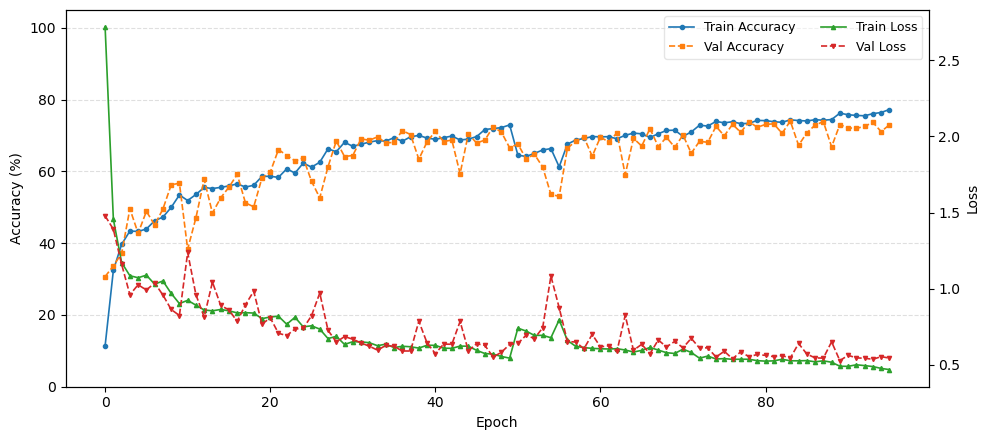

In [6]:
# plot_learning_curves.py
import json, os
from glob import glob
import matplotlib.pyplot as plt

pattern = "epoch_metrics*.json"
out_pdf = "figures/learning_curves_vit.pdf"
out_png = "figures/learning_curves_vit.png"

def parse_epoch_file(path):
    with open(path, "r") as f:
        data = json.load(f)
    records = data if isinstance(data, list) else data.get("epochs", data.get("history", []))

    ep, tr_acc, va_acc, tr_loss, va_loss = [], [], [], [], []
    for i, r in enumerate(records):
        e = r.get("epoch", i)
        ta = r.get("train_acc", r.get("train_accuracy"))
        va = r.get("val_acc", r.get("val_accuracy"))
        tl = r.get("train_loss", r.get("loss", r.get("train", {}).get("loss")))
        vl = r.get("val_loss", r.get("val", {}).get("loss"))
        if ta is None and va is None and tl is None and vl is None:
            continue
        if ta is not None and 0 <= ta <= 1: ta *= 100
        if va is not None and 0 <= va <= 1: va *= 100
        ep.append(int(e))
        tr_acc.append(ta if ta is not None else None)
        va_acc.append(va if va is not None else None)
        tr_loss.append(tl if tl is not None else None)
        va_loss.append(vl if vl is not None else None)
    return ep, tr_acc, va_acc, tr_loss, va_loss

files = sorted(glob(pattern))
if not files:
    raise FileNotFoundError("No epoch_metrics*.json files found.")

all_ep, all_tr_acc, all_va_acc, all_tr_loss, all_va_loss = [], [], [], [], []
offset = 0
for p in files:
    ep, tra, vaa, trl, val = parse_epoch_file(p)
    for i in range(len(ep)):
        all_ep.append(offset + i)
        all_tr_acc.append(tra[i])
        all_va_acc.append(vaa[i])
        all_tr_loss.append(trl[i])
        all_va_loss.append(val[i])
    offset += len(ep)

os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
fig, ax1 = plt.subplots(figsize=(10, 4.5))

# ---- ensure 4 distinct colors across both axes ----
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3'])
c0 = cycle_colors[0 % len(cycle_colors)]
c1 = cycle_colors[1 % len(cycle_colors)]
c2 = cycle_colors[2 % len(cycle_colors)]
c3 = cycle_colors[3 % len(cycle_colors)]

# Accuracy (left axis)
acc_train_line, = ax1.plot(all_ep, all_tr_acc, linestyle='-', marker='o',
                           linewidth=1.2, markersize=3, label="Train Accuracy", color=c0)
acc_val_line,   = ax1.plot(all_ep, all_va_acc, linestyle='--', marker='s',
                           linewidth=1.2, markersize=3, label="Val Accuracy",   color=c1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(0, 105)
ax1.grid(axis="y", linestyle="--", alpha=0.4)

# Loss (right axis)
ax2 = ax1.twinx()
loss_train_line, = ax2.plot(all_ep, all_tr_loss, linestyle='-', marker='^',
                            linewidth=1.2, markersize=3, label="Train Loss", color=c2)
loss_val_line,   = ax2.plot(all_ep, all_va_loss, linestyle='--', marker='v',
                            linewidth=1.2, markersize=3, label="Val Loss",   color=c3)
ax2.set_ylabel("Loss")

# Combined legend (semi-transparent frame)
lines = [acc_train_line, acc_val_line, loss_train_line, loss_val_line]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, ncols=2, fontsize=9, frameon=True, framealpha=0.5, loc="upper right")

fig.tight_layout()
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Saved: {out_pdf}, {out_png}")
